<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>
required modules: <b>lime, shap, pdpbox</b><code>
> pip install lime
> pip install shap
> pip install pdpbox
</code>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
# load dataset
df = pd.read_csv("data/adult_continuous.csv", sep=',', na_values='?')
del df['fnlwgt']
# impute missing/outlier values
df.loc[ df['workclass']=='?', 'workclass']= df['workclass'].mode()
df.loc[ df['occupation']=='?', 'occupation']= df['occupation'].mode()
df.loc[ df['native-country']=='?', 'native-country']= df['native-country'].mode()
df.loc[ df['capital-gain']==99999, 'capital-gain']= df['capital-gain'].mean()
# target class
target = 'class'
# output info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  int64  
 1   workclass       46043 non-null  object 
 2   education       48842 non-null  object 
 3   education-num   48842 non-null  int64  
 4   marital-status  48842 non-null  object 
 5   occupation      46033 non-null  object 
 6   relationship    48842 non-null  object 
 7   race            48842 non-null  object 
 8   sex             48842 non-null  object 
 9   capital-gain    48842 non-null  float64
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  int64  
 12  native-country  47985 non-null  object 
 13  class           48842 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 5.2+ MB


In [3]:
# pre-processing steps needed for scikit-learn classifiers
# encode class values into 0 - 1
df[target] = df[target].apply(lambda x: 0 if x == "<=50K" else 1).astype(np.int)
target_values = ["<=50K", ">50K"]
# category cols: dummy encoding
cat = df.select_dtypes('object').columns
one_hot = pd.get_dummies(df[cat],  prefix_sep='=')
df = pd.concat([df.drop(cat, axis=1), one_hot], axis=1)
#print(df.columns.tolist())

In [4]:
df

,age,education-num,capital-gain,capital-loss,hours-per-week,class,workclass=Federal-gov,workclass=Local-gov,workclass=Never-worked,workclass=Private,...,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia
0,39,13,2174.0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0.0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0.0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0.0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0.0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,13,0.0,0,36,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,64,9,0.0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,13,0.0,0,50,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48840,44,13,5455.0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# training-test split 60%-40%
from sklearn.model_selection import train_test_split

attributes = [col for col in df.columns if col != target]
X = df[attributes]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100, stratify=y)
X_train.shape, X_test.shape

((29305, 104), (19537, 104))

In [6]:
# black box learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score

bb = GradientBoostingClassifier(n_estimators=100)
bb.fit(X_train, y_train)

y_pred = bb.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.8678
F1-score: 0.6891


In [7]:
# surrogate model assuming to know the training data
from sklearn.tree import DecisionTreeClassifier

sm = DecisionTreeClassifier(max_depth=3)
sm.fit(X_train, bb.predict(X_train))

sm_pred = sm.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, sm_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test, sm_pred)))
print('Fidelity: {:.4f}'.format(accuracy_score(y_pred, sm_pred)))

Accuracy: 0.8450
F1-score: 0.6202
Fidelity: 0.9420


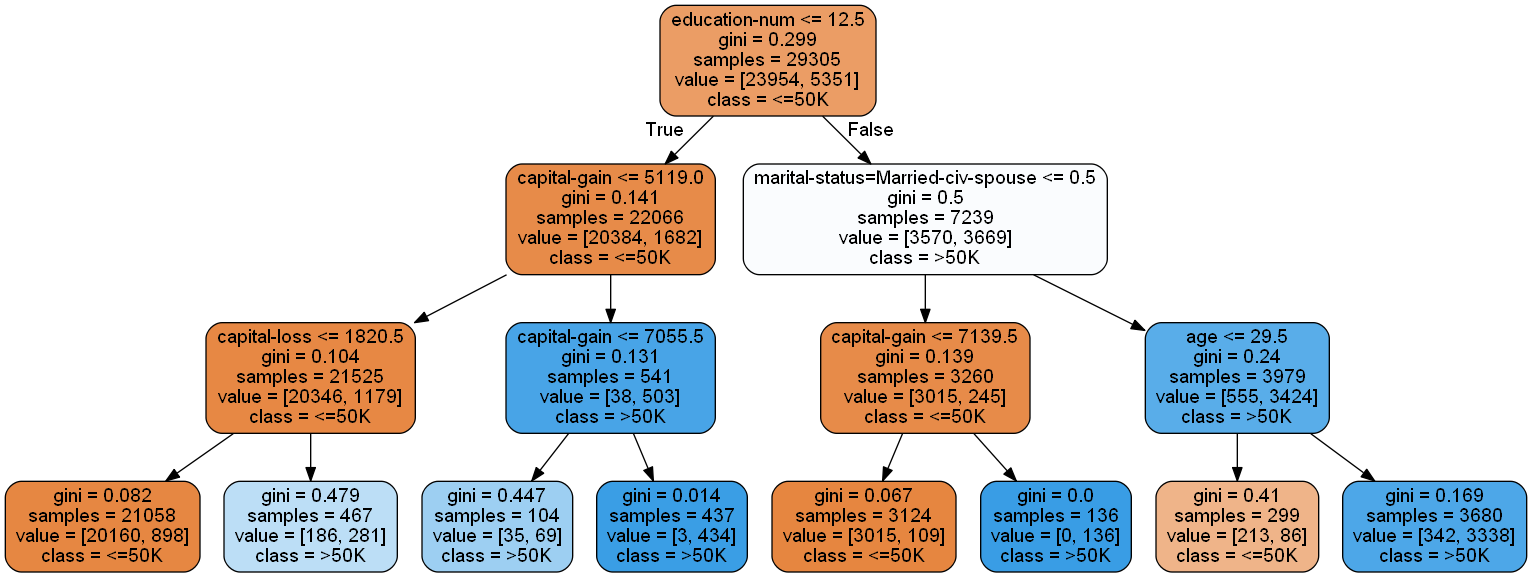

In [8]:
# visualize surrogate model
import pydotplus
from sklearn import tree
from IPython.display import Image
import graphviz
import os

# add if needed
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(sm, out_file=None, feature_names=attributes, 
                                class_names=target_values,
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
# surrogate model assuming NOT to know the training data
sm = DecisionTreeClassifier(max_depth=3)
# use half of the test data for training surrogate model
half = int(len(X_test)/2) 
X_surr_train = X_test[:half]
X_surr_test = X_test[half:]
sm.fit(X_surr_train, bb.predict(X_surr_train))

sm_pred = sm.predict(X_surr_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test[half:], sm_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test[half:], sm_pred)))
print('Fidelity: {:.4f}'.format(accuracy_score(y_pred[half:], sm_pred)))

Accuracy: 0.8409
F1-score: 0.6191
Fidelity: 0.9413


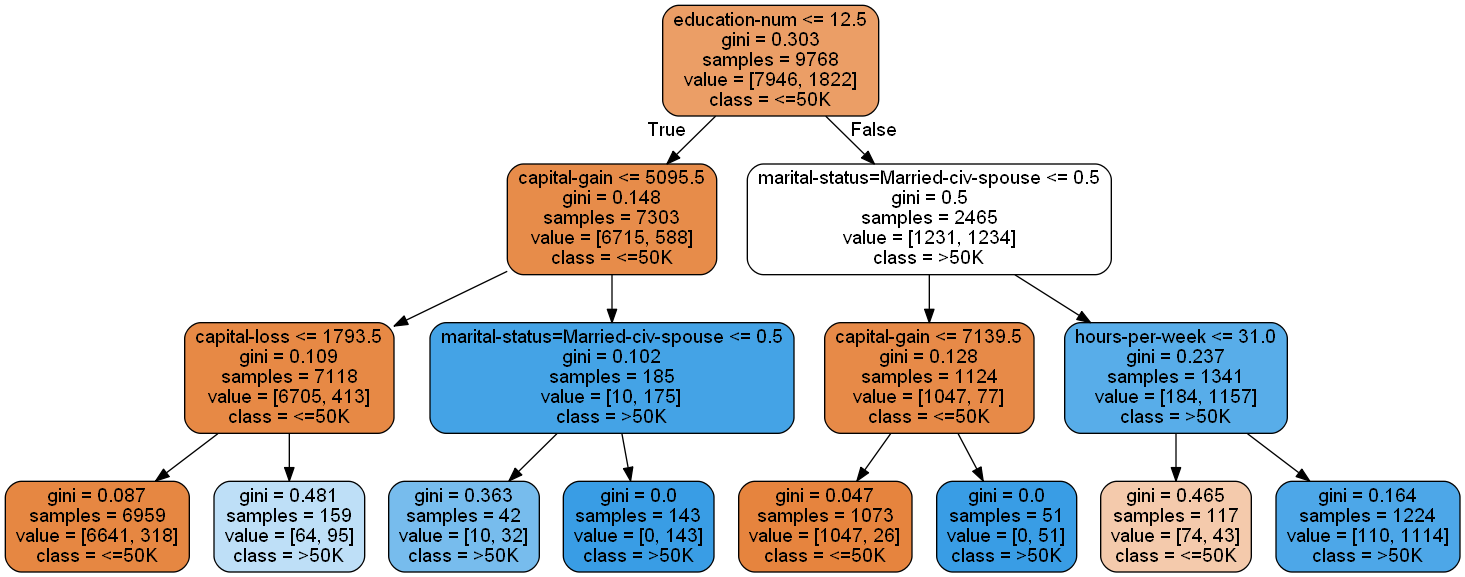

In [10]:
# visualize surrogate model
dot_data = tree.export_graphviz(sm, out_file=None, feature_names=attributes, 
                                class_names=target_values,
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [11]:
# local explanations
# select an instance to explain
inst = X_test.iloc[3]
inst

age                               22.0
education-num                     11.0
capital-gain                       0.0
capital-loss                       0.0
hours-per-week                    35.0
                                  ... 
native-country=Thailand            0.0
native-country=Trinadad&Tobago     0.0
native-country=United-States       1.0
native-country=Vietnam             0.0
native-country=Yugoslavia          0.0
Name: 36815, Length: 104, dtype: float64

In [12]:
# LIME
from lime.lime_tabular import LimeTabularExplainer
# LimeTabularExplainer require a dataset to extract distributions from
lime_explainer = LimeTabularExplainer(X_test, feature_names=attributes,
                                           class_names=target_values, discretize_continuous=False)

In [13]:
# explain instance
exp = lime_explainer.explain_instance(inst, bb.predict_proba)
# as attribute, weight
exp.local_exp

{1: [(31, 0.08190039104103648),
  (1, 0.06833297545939555),
  (4, 0.04625926406002531),
  (0, 0.044819995039059896),
  (2, 0.03337110829076837),
  (39, 0.014418692081992165),
  (53, -0.0077241586027089765),
  (61, -0.007138594727769757),
  (10, -0.002656481670703324),
  (21, -0.0006838147385339147)]}

In [14]:
exp.show_in_notebook()

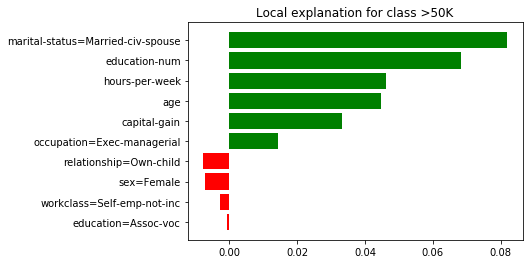

In [15]:
fig = exp.as_pyplot_figure()

In [16]:
# SHAP
import shap

shap.initjs()

In [17]:
f = lambda x: bb.predict_proba(x)[:, 1]
med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)

In [18]:
shap_values_single = shap_explainer.shap_values(inst, nsamples=1000, l1_reg='aic')

In [19]:
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=inst, feature_names=attributes)

In [20]:
shap_values = shap_explainer.shap_values(X_test[0:100], nsamples=1000, l1_reg='aic')
shap.force_plot(shap_explainer.expected_value, shap_values, X_test[0:100], feature_names=attributes)

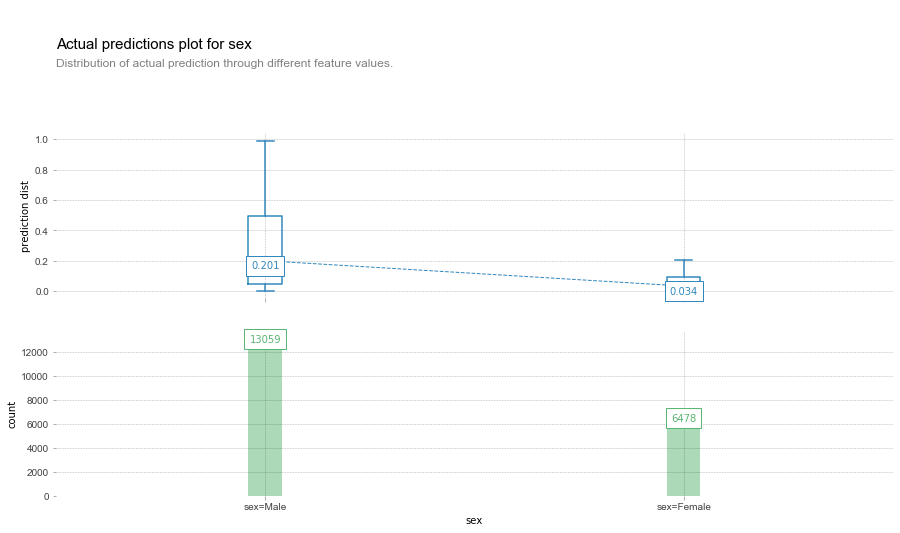

In [21]:
# model inspection: PDP
from pdpbox import pdp, get_dataset, info_plots
# distributions of predictions
fig, axes, summary_df = info_plots.actual_plot(bb, X_test, feature=['sex=Male', 'sex=Female'], 
                                               feature_name='sex', predict_kwds={})

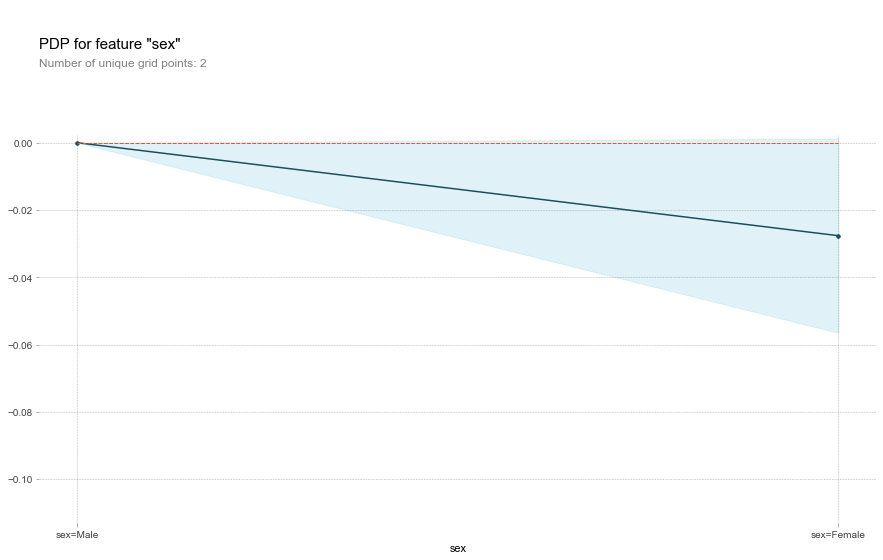

In [22]:
# centered PDP
pdp_sex = pdp.pdp_isolate(bb, X_test, model_features=attributes, feature=['sex=Male', 'sex=Female'])
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', center=True)

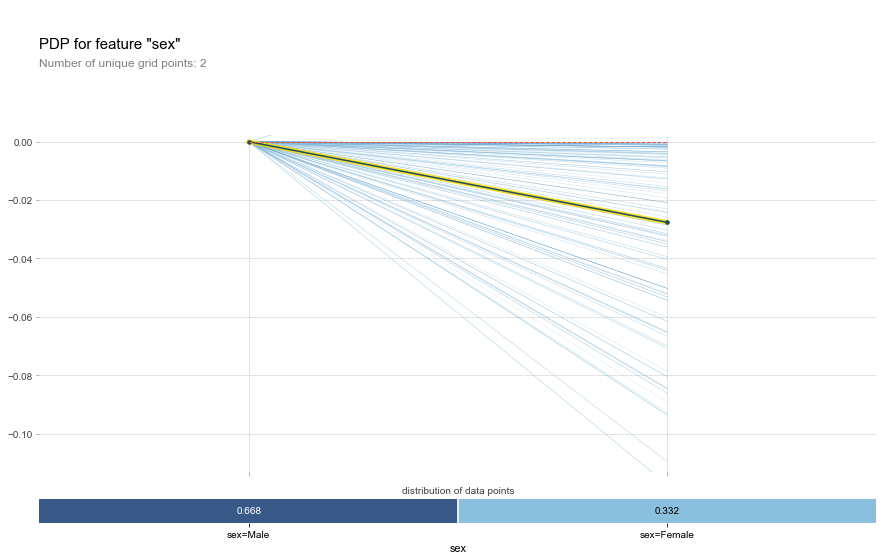

In [23]:
# ICE
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

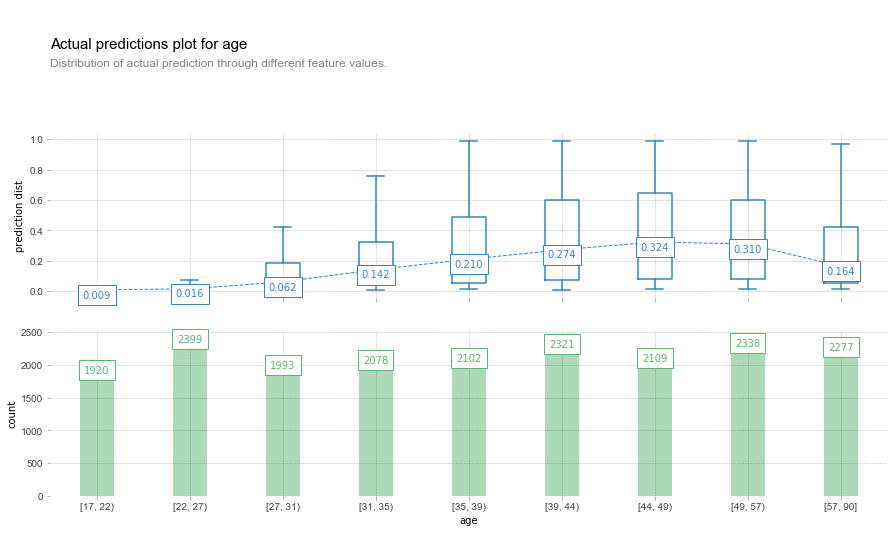

In [24]:
# age
fig, axes, summary_df = info_plots.actual_plot(bb, X_test, feature='age', feature_name='age', predict_kwds={})

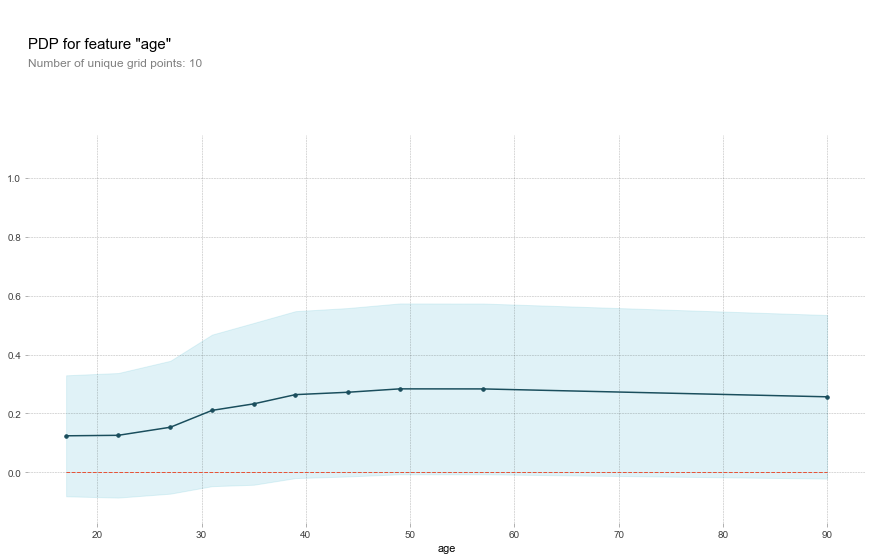

In [25]:
# centered PDP
pdp_age = pdp.pdp_isolate(bb, X_test, model_features=attributes, feature='age')
fig, axes = pdp.pdp_plot(pdp_age, 'age', center=False)

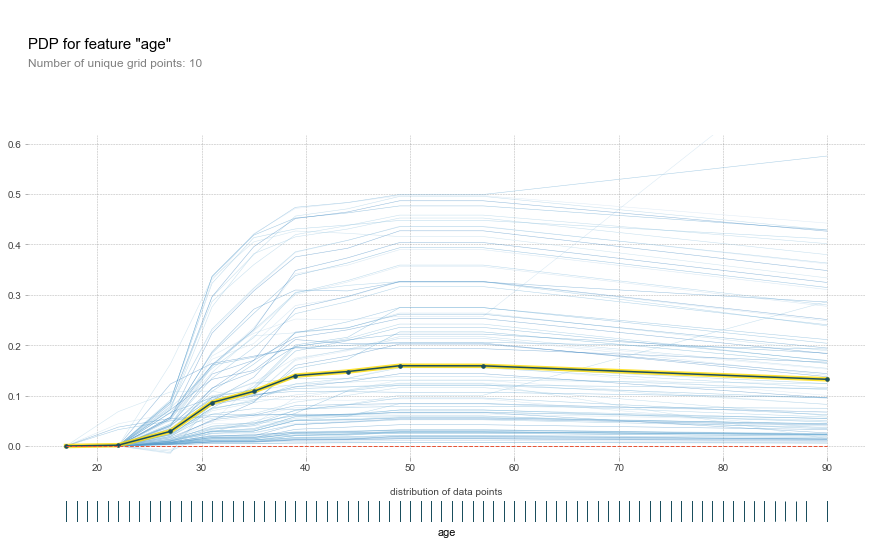

In [26]:
# ICE
fig, axes = pdp.pdp_plot(pdp_age, 'age', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)